In [76]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
import glob, os, gc
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.model_selection import KFold

# Add the path to the directory containing the module
import sys
sys.path.append('../../')
from util.ml import baseline, metrics, nestedMLR, fno

In [43]:
from natsort import natsorted
from scipy.stats import genextreme
# shape, loc, scale
clusters = [pd.read_csv(natsorted(glob.glob('../../datas/GEV_parameters/*'))[i]).iloc[:,1].values for i in range(15)]
# data for Cluster 4
cluster4 = pd.read_csv('../../datas/wind_data_cluster_3.csv').iloc[:,1].values

In [44]:
cluster4

array([ 8.65948224,  8.83121406,  9.14645606, ..., 40.79737304,
       41.50597099, 41.74005541])

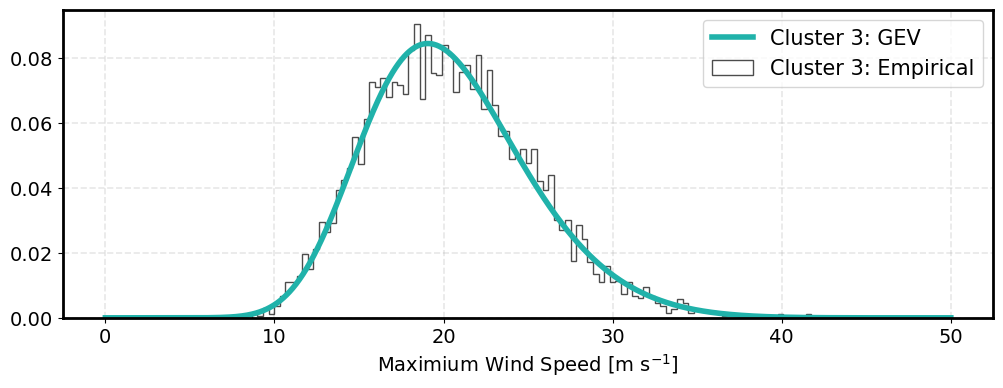

In [77]:
# visualize the pdf of the GEV distribution using the parameters
i = 10
x = np.linspace(0,50, 2000)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x, genextreme.pdf(x, clusters[3][0], clusters[3][1], clusters[3][2]),lw=4, label='Cluster 3: GEV',c='lightseagreen')
# Plot an empirical CDF of the cluster4 data
ax.hist(cluster4, bins=100, density=True, histtype='step', color='k', lw=1, label='Cluster 3: Empirical',alpha=0.7)
#plt.plot(x, genextreme.pdf(x, clusters[10][0], clusters[10][1], clusters[10][2]),lw=2, label='Cluster 11',c='tab:red')

# Customize labels and title
ax.set_xlabel('Maximium Wind Speed [m s$^{-1}$]', fontsize=14)
#ax.set_ylabel('Test RMSE', fontsize=14)
#ax.set_title('Test RMSE vs. Number of Features', fontsize=16)

# Add grid for better readability
ax.grid(lw=1.2, ls='--', alpha=0.3)

# Add legend
ax.legend(loc='upper right', fontsize=15, frameon=True)

# Adjust ticks
ax.tick_params(axis='both', which='major', labelsize=14)

# Thicken spines
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the spine thickness

plt.savefig('./figs/GEV_pdf.png', dpi=300, bbox_inches='tight')
plt.show()


## GEV coefficients

In [63]:
shape_dict = {ind: clusters[ind][0] for ind in range(15)}
loc_dict = {ind: clusters[ind][1] for ind in range(15)}
scale_dict = {ind: clusters[ind][2] for ind in range(15)}


In [64]:
# Combine the three dictionaries into a Pandas DataFrame
df = pd.DataFrame([shape_dict, loc_dict, scale_dict], index=['Shape', 'Location', 'Scale'])
# Transpose the dataframe
df = df.T

In [59]:
import matplotlib.colors as mcolors
# Create a discrete colormap based on the unique cluster values
cmap = plt.cm.get_cmap('gist_ncar', 15)  # Ensure discrete colormap with same colors

# Map cluster numbers to indices
norm = mcolors.BoundaryNorm(boundaries=np.arange(15 + 1), 
                            ncolors=15)

In [65]:
colors = ['#000080','#003c5c','#0085ff','#00fdee','#00fc5f','#4dd900','#85ff0d','#d8ff22','#ffe000','#ffa20b','#ff2500','#ff00db',
          '#ae42fb','#f1a4f3','#fef8fe']

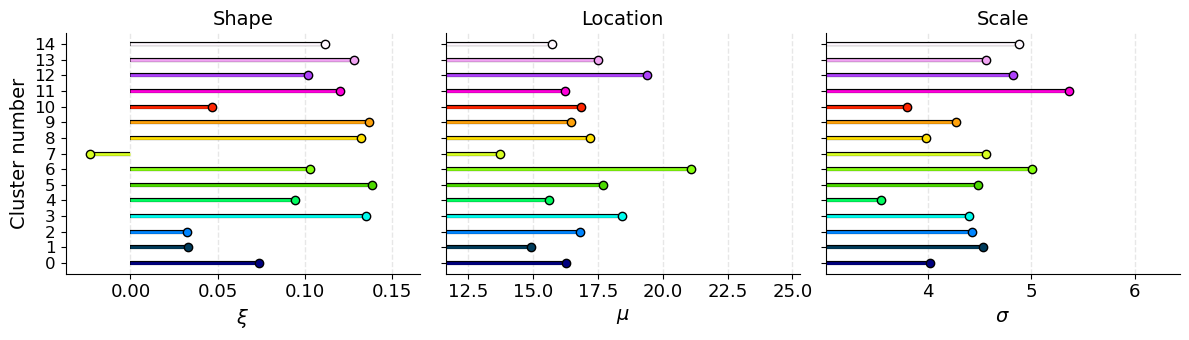

In [80]:
# Create a figure with 1 row and 3 columns
from matplotlib.patheffects import withStroke
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)  # Share y-axis for consistency
xlabel = ['$\\xi$', '$\\mu$', '$\\sigma$']  # Greek letters for labels
# Iterate over columns and corresponding axes
for ax, (col_name, col_values) in zip(axes, df.items()):
    # Create horizontal line plot for each variable
    for i, value in enumerate(col_values):
        hline = ax.hlines(y=i, xmin=0, xmax=value, color=colors[i], lw=2)
        hline.set_path_effects([withStroke(linewidth=3, foreground='black')])
        ax.scatter(value, i, color=colors[i], edgecolor='black', zorder=3)  # Add markers at ends of lines
    
    # Customize axes
    ax.set_title(col_name, fontsize=14, weight='normal')
    ax.set_xlim(col_values.min()-col_values.max()/10, col_values.max() + col_values.max()/5)  # Adjust x-axis limits based on data
    ax.set_yticks(range(len(df)))      # Set y-ticks to match the number of rows
    ax.set_yticklabels([])            # Remove y-tick labels for cleaner look
    ax.set_xlabel(xlabel.pop(0), fontsize=14, weight='normal')  # Add x-axis labels
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(lw=1, ls='--', alpha=0.3, axis='x')  # Add vertical gridlines
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Shared y-axis label
axes[0].set_yticklabels(df.index)  # Add y-tick labels for the first plot
axes[0].set_ylabel('Cluster number', fontsize=14, weight='normal')

# Adjust layout
plt.tight_layout()
plt.savefig('./figs/GEV_params.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
#@title Double click to see the Pareto functions' code

def is_pareto_efficient_simple(costs):

    """
    Identify the Pareto-efficient points for a given set of costs.

    Parameters:
    costs (np.array): A 2D NumPy array where each row represents an individual point
                      in terms of its cost dimensions. For instance, each row could
                      represent a different configuration's cost as [cost1, cost2].

    Returns:
    np.array: A boolean array where True indicates that the corresponding point in
              'costs' is Pareto efficient.

    Description:
    This function iterates over each point and determines whether it is dominated
    by any other point. A point is considered Pareto efficient if no other point
    exists that is better in all cost dimensions. In this context, "better" is
    defined as being lower for each cost dimension since we are minimizing.

    The function uses a boolean array, `is_efficient`, to keep track of which
    points are currently considered Pareto efficient. Initially, all points are
    assumed to be Pareto efficient.

    For each point:
    1. If the point is still considered potentially Pareto efficient (`is_efficient[i]` is True),
       it checks against all other points that are also still marked as efficient.
    2. It updates the `is_efficient` array by setting it to False for any point
       that is dominated by the current point. A point `j` is dominated by point `i`
       if all its cost dimensions are greater than or equal to those of point `i`
       and at least one dimension is strictly greater.
    3. It ensures the current point's efficiency status remains True regardless of the
       comparison outcome by resetting `is_efficient[i]` to True after the comparison.

    The loop ensures that every point is compared with all others, and after processing,
    the `is_efficient` array flags only those points that are not dominated by any other,
    indicating the Pareto front.
    """

    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

def extract_pareto_data(dataframe, key_substrings,
                        original_dict=None, new_point_1_mse_scores=700, new_point_2_parameters=5.4,
                        key_x='Complexity/Number of parameters', key_y='MSE scores on validation set'):

    # Filter keys by substrings
    filtered_keys = {
        key for key in original_dict
        if any(sub in key for sub in key_substrings)
    }

    # Extract parameters and MSE scores for the filtered models
    parameters = [np.log10(dataframe[key_x][k]) for k in filtered_keys]
    mse_scores = [dataframe[key_y][k] for k in filtered_keys]

    # Determine Pareto optimal points
    pareto_points = is_pareto_efficient_simple(np.column_stack((parameters, mse_scores)))

    # Extract current Pareto points
    pareto_parameters = np.array(parameters)[pareto_points]
    pareto_mse_scores = np.array(mse_scores)[pareto_points]

    # Sort the initial Pareto points based on parameters
    sorted_indices = np.argsort(pareto_parameters)
    pareto_parameters = pareto_parameters[sorted_indices]
    pareto_mse_scores = pareto_mse_scores[sorted_indices]

    # Define new points
    new_point_1_parameters = min(parameters)  # Minimum of all parameters
    new_point_2_mse_scores = min(mse_scores)  # Minimum of all scores

    # Insert new point 1 at the beginning
    pareto_parameters = np.insert(pareto_parameters, 0, new_point_1_parameters)
    pareto_mse_scores = np.insert(pareto_mse_scores, 0, new_point_1_mse_scores)

    # Append new point 2 at the end
    pareto_parameters = np.append(pareto_parameters, new_point_2_parameters)
    pareto_mse_scores = np.append(pareto_mse_scores, new_point_2_mse_scores)

    return parameters, mse_scores, pareto_parameters, pareto_mse_scores, filtered_keys


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame
data = {
    'Model ID': ['A', 'B', 'C', 'D', 'E'],
    'Complexity/Number of parameters': [1e3, 2e3, 1.5e3, 5e3, 1e4],
    'MSE scores on validation set': [0.1, 0.2, 0.15, 0.25, 0.22]
}
df = pd.DataFrame(data)

# Filter models based on substrings (e.g., model identifiers like 'A', 'B')
key_substrings = ['A', 'B', 'C', 'D', 'E']

# Use the function to extract Pareto data
parameters, mse_scores, pareto_parameters, pareto_mse_scores, filtered_keys = extract_pareto_data(
    dataframe=df.set_index('Model ID'),  # Set 'Model ID' as the index
    original_dict=data,
    key_substrings=key_substrings,
    key_x='Complexity/Number of parameters',
    key_y='MSE scores on validation set'
)

# Plot the data and the Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(parameters, mse_scores, label='All Models', color='blue', alpha=0.6)
plt.plot(pareto_parameters, pareto_mse_scores, label='Pareto Front', color='red', linewidth=2, marker='o')
plt.xlabel('log(Number of Parameters)', fontsize=12)
plt.ylabel('MSE Scores', fontsize=12)
plt.title('Pareto Front Visualization', fontsize=14)
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.show()

KeyError: 'MSE scores on validation set'